In [1]:
# %pip install matplotlib
# %pip install tqdm  
from torch.utils.data import DataLoader
from utils.dataset import VCTKDataset
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
from src.model.cvae_tacotron_wrapper import CVAETacotron2, cvae_taco_loss
import argparse
from matplotlib import pyplot as plt
import ipywidgets
from tqdm.notebook import tqdm



In [2]:
dataset = VCTKDataset("./dataset/VCTK",)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0,
                    collate_fn=VCTKDataset.collate_cvae)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Selected speakers: ['p323', 'p301', 'p240', 'p299', 'p225', 'p285', 'p252', 'p279', 'p287', 'p311']
Speaker 0: p323: F, 19yo, SouthAfrican (Pretoria)
Speaker 1: p301: F, 23yo, American (North Carolina)
Speaker 2: p240: F, 21yo, English (Southern England)
Speaker 3: p299: F, 25yo, American (California)
Speaker 4: p225: F, 23yo, English (Southern England)
Speaker 5: p285: M, 21yo, Scottish (Edinburgh)
Speaker 6: p252: M, 22yo, Scottish (Edinburgh)
Speaker 7: p279: M, 23yo, English (Leicester)
Speaker 8: p287: M, 23yo, English (York)
Speaker 9: p311: M, 21yo, American (Iowa)
Using device: cuda


Using device: cuda


Using cache found in C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Epoch 1/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 1/10] Loss: 0.5741 | l1: 0.5407, gate: 0.0333, kl: 1.4102


Epoch 2/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 2/10] Loss: 0.4621 | l1: 0.4434, gate: 0.0185, kl: 2.1494


Epoch 3/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 3/10] Loss: 0.4540 | l1: 0.4358, gate: 0.0180, kl: 2.5525


Epoch 4/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 4/10] Loss: 0.4402 | l1: 0.4224, gate: 0.0175, kl: 2.6943


Epoch 5/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 5/10] Loss: 0.4434 | l1: 0.4258, gate: 0.0172, kl: 2.7987


Epoch 6/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 6/10] Loss: 0.4330 | l1: 0.4157, gate: 0.0170, kl: 2.9368


Epoch 7/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 7/10] Loss: 0.4314 | l1: 0.4141, gate: 0.0170, kl: 3.0108


Epoch 8/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 8/10] Loss: 0.4284 | l1: 0.4112, gate: 0.0170, kl: 3.0713


Epoch 9/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 9/10] Loss: 0.4263 | l1: 0.4091, gate: 0.0169, kl: 3.2102


Epoch 10/10:   0%|          | 0/122 [00:00<?, ?it/s]

[Epoch 10/10] Loss: 0.4303 | l1: 0.4133, gate: 0.0166, kl: 3.2480


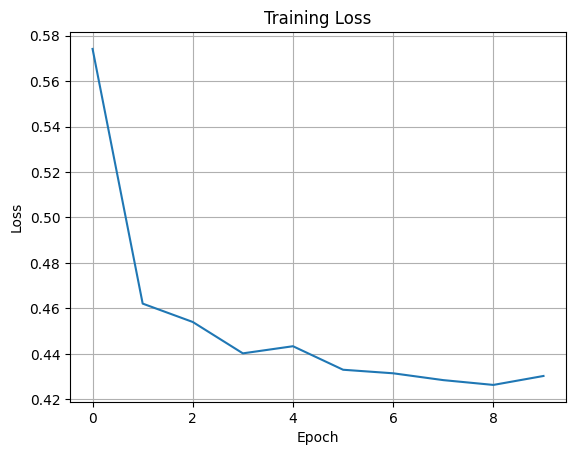

Model saved to src\model\cvae_tacotron2_trial1.pth


In [3]:
EPOCH = 10
BATCH_SIZE = 32
LR = 1e-3



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CVAETacotron2(ckpt_path="./src/model/tacotron2_pretrained.pt", z_dim=64, spk_dim_raw=256, spk_dim_proj=128)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()

loss_tracker = []

for epoch in range(EPOCH):
    loss_sum = 0
    logsum = {'l1': 0, 'gate': 0, 'kl': 0}

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCH}", leave=False, position=0, dynamic_ncols=True)

    for text, text_len, mel, mel_len, gate, spk_id in pbar:
        text, text_len = text.to(device), text_len.to(device)
        mel, gate = mel.to(device), gate.to(device)
        spk_emd = model.spk_emb[spk_id].to(device)

        mel_post, mel_out, gate_out, mu, logvar = model(text, text_len, mel, spk_emd)
        loss, logs = cvae_taco_loss(mel_post, mel, gate_out, gate, mu, logvar)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        logsum['l1'] += logs['l1']
        logsum['gate'] += logs['gate']
        logsum['kl'] += logs['kl']

        pbar.set_postfix(loss=loss.item(), l1=logs['l1'], gate=logs['gate'], kl=logs['kl'])

    loss_avg = loss_sum / len(dataloader)
    loss_tracker.append(loss_avg)
    print(f"[Epoch {epoch+1}/{EPOCH}] Loss: {loss_avg:.4f} | l1: {logsum['l1'] / len(dataloader):.4f}, gate: {logsum['gate'] / len(dataloader):.4f}, kl: {logsum['kl'] / len(dataloader):.4f}")

plt.plot(loss_tracker)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

model_save_path = Path("./src/model/cvae_tacotron2_trial1.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")